# Image Classifier

```shell
python -m venv .venv
.\.venv\Scripts\activate
pip install -r requirements.txt
```

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SparseCategoricalAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

from openimages.download import download_dataset # For downloading image dataset
import glob

import torch



C:\Users\Plasc\AppData\Local\Temp\ipykernel_13280\156411660.py:11: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Download The Images

In [2]:
def Download():
    download_dir = "data"
    download_amount_per_class = 200
    if not os.path.isdir(download_dir):
        download_dataset(download_dir, ["Dog", "Cat", "Elephant", "Sheep", "Spider", "Squirrel"], limit=download_amount_per_class)

Download()

## Configure DataSet

In [3]:
data_dir_path = "data"
image_classes = os.listdir(data_dir_path)
classes_amount = len(image_classes)
classes_amount

6

In [4]:
data_set = tf.keras.utils.image_dataset_from_directory(data_dir_path) # makes images (256, 256), shuffles, batches
data_set = data_set.map(lambda x,y: (x/255, y)) # rescaling rgb values to be [0, 1]

Found 1200 files belonging to 6 classes.


### View Some Images

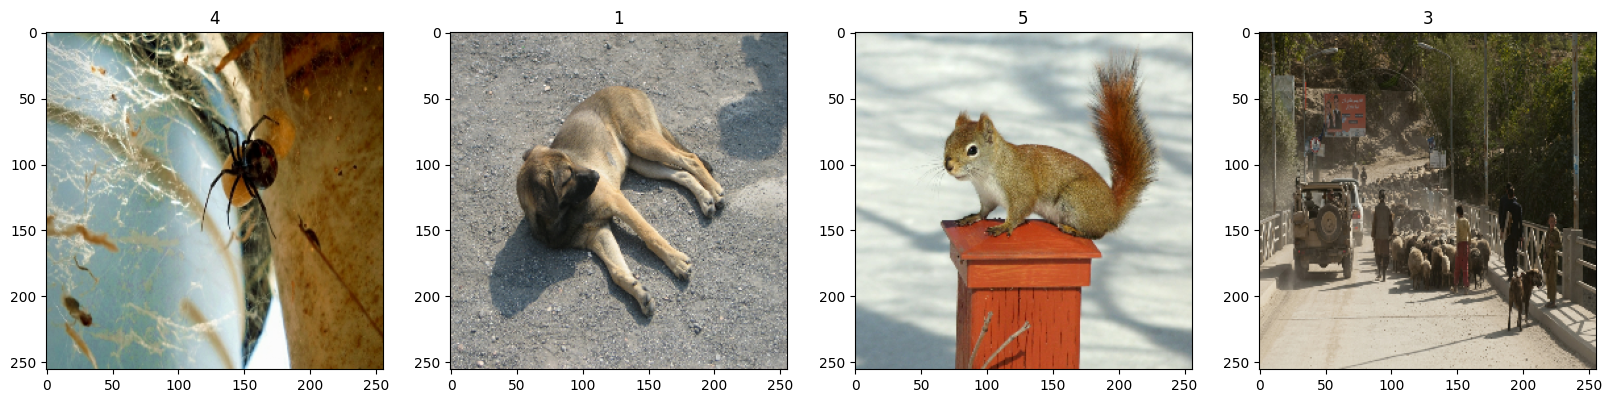

In [5]:
# 0 - cat
# 1 - dog
# 2 - elephant
# 3 - sheep
# 4 - spider
# 5 - squirle
data_iterator = data_set.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split Data Set

In [6]:
train_size = int(len(data_set)*.6)
validation_size = int(len(data_set)*.2)
test_size = int(len(data_set)*.2)

train_data_set = data_set.take(train_size)
validation_data_set = data_set.skip(train_size).take(validation_size)
test_data_set = data_set.skip(train_size + validation_size).take(test_size)

(train_size, validation_size, test_size)

(22, 7, 7)

## Define The Model

In [7]:
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),

    Conv2D(32, (3, 3), 1, activation='relu'),
    MaxPooling2D(),

    Conv2D(16, (3, 3), 1, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu'),
    Dense(classes_amount, activation='softmax')
])

model.compile('adam', loss=tf._losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,910 (14.11 MB)

 Trainable params: 3,697,910 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

## Train The Model

In [8]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.metrics import SparseCategoricalAccuracy

# optimizer = Adam()
# loss_fn = SparseCategoricalCrossentropy()
# accuracy_metric = SparseCategoricalAccuracy()

# epochs = 10
# for epoch in range(epochs):
#     print(f'Start of Epoch {epoch+1}')
#     for step, (x_batch_train, y_batch_train) in enumerate(train_data_set):
#         with tf.GradientTape() as tape:
#             logits = model(x_batch_train, training=True)
#             loss_value = loss_fn(y_batch_train, logits)
#         grads = tape.gradient(loss_value, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         accuracy_metric.update_state(y_batch_train, logits)

Start of Epoch 1
Training loss (for one batch) at step 0: 1.7532052993774414
Seen so far: 32 samples
Start of Epoch 2
Training loss (for one batch) at step 0: 1.7519748210906982
Seen so far: 32 samples
Start of Epoch 3
Training loss (for one batch) at step 0: 1.5295813083648682
Seen so far: 32 samples
Start of Epoch 4
Training loss (for one batch) at step 0: 1.3631343841552734
Seen so far: 32 samples
Start of Epoch 5
Training loss (for one batch) at step 0: 1.2939903736114502
Seen so far: 32 samples
Start of Epoch 6
Training loss (for one batch) at step 0: 0.8181394338607788
Seen so far: 32 samples
Start of Epoch 7
Training loss (for one batch) at step 0: 0.604191780090332
Seen so far: 32 samples
Start of Epoch 8
Training loss (for one batch) at step 0: 0.4054257571697235
Seen so far: 32 samples
Start of Epoch 9
Training loss (for one batch) at step 0: 0.15391245484352112
Seen so far: 32 samples
Start of Epoch 10
Training loss (for one batch) at step 0: 0.05945734307169914
Seen so far:

In [8]:
log_dir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

hist = model.fit(train_data_set, epochs=15, validation_data=validation_data_set, callbacks=[tensorboard_callback])

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.1956 - loss: 1.9379 - val_accuracy: 0.2946 - val_loss: 1.7546
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.3099 - loss: 1.7144 - val_accuracy: 0.3348 - val_loss: 1.7026
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.4334 - loss: 1.4926 - val_accuracy: 0.4509 - val_loss: 1.5457
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.5814 - loss: 1.2712 - val_accuracy: 0.4777 - val_loss: 1.4394
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.6324 - loss: 1.0751 - val_accuracy: 0.5446 - val_loss: 1.2842
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.7947 - loss: 0.7300 - val_accuracy: 0.5893 - val_loss: 1.1711
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.8607 - loss: 0.5314 - val_accuracy: 0.6161 - val_loss: 1.1156
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.9083 - loss: 0.3488 - val_accuracy: 

## Plot The Training History

### Loss & Accuracy

NameError: name 'hist' is not defined

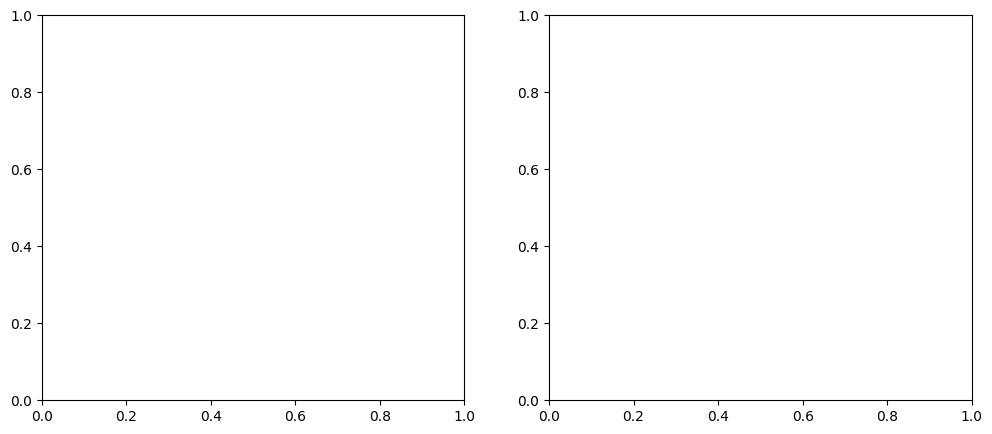

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(hist.history['loss'], color='teal', label='loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss', fontsize=20)
axs[0].legend(loc='upper left')

axs[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy', fontsize=20)
axs[1].legend(loc='upper left')

plt.tight_layout()

plt.show()

## Evaluating Performance

In [17]:
precision = Precision()
recall = Recall()
accuracy = SparseCategoricalAccuracy()

for batch in test_data_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    accuracy.update_state(y, yhat)

    yhat_classes = tf.argmax(yhat, axis=1)
    precision.update_state(y, yhat_classes)
    recall.update_state(y, yhat_classes)

f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [18]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}, F1: {f1_score}')

Precision: 0.8967136144638062, Recall: 0.9646464586257935, Accuracy: 0.5089285969734192, F1: 0.9294404075259604


### Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


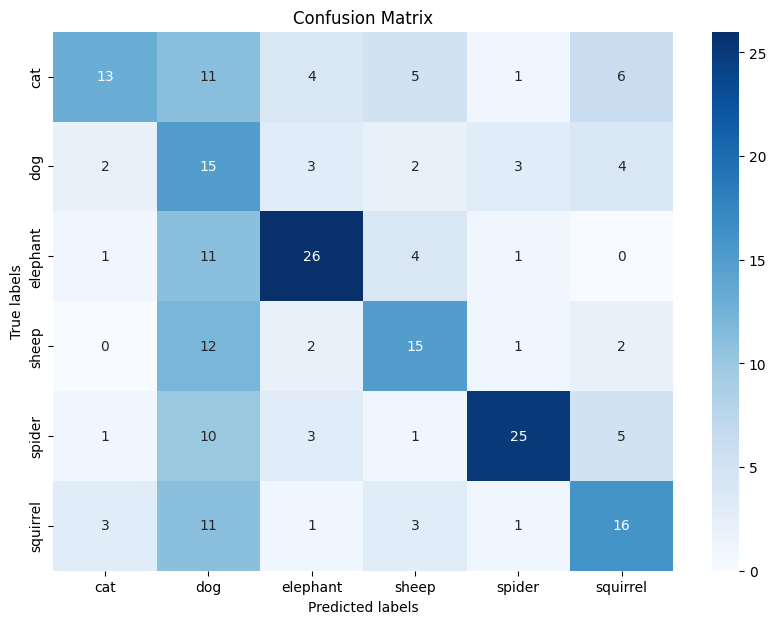

In [13]:
true_labels = []
predicted_labels = []

for batch in test_data_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=1)
    true_labels.extend(y)
    predicted_labels.extend(yhat_classes)

cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3, 4, 5])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=image_classes, yticklabels=image_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Expose The Model Via API Endpoint

In [16]:
from fastapi import FastAPI, File, UploadFile
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import io
import uvicorn
import nest_asyncio
import multipart


app = FastAPI()

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    image_data = await file.read()
    image = Image.open(io.BytesIO(image_data))
    image = image.resize((256, 256))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    return {"predicted_class": image_classes[int(predicted_class)]}


if __name__ == "__main__":
    nest_asyncio.apply()
    uvicorn.run(app)

INFO:     Started server process [13280]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:57864 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:57864 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:57866 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:57864 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:57864 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:57866 - "GET /docs HTTP/1.1" 200 OK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
INFO:     127.0.0.1:57865 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [13280]
